<a href="https://colab.research.google.com/github/resquilleur/TestWorkNeowoxCC/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Часть 1. Загрузка и обработка данных. Подготовка наборов к обучению.

## Импорт библиотек

In [ ]:
%cd TestWorkNeowoxCC

In [ ]:
# !pip install pymorphy2

In [ ]:
import pandas as pd
import numpy as np
import pymorphy2
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Загрузка и обработка наборов данных

In [ ]:
# загрузим набор данных
data_train = pd.read_csv('data/for_test_train.csv').drop(columns=['Unnamed: 0'])
# посмотрим кол-во экземпляров по классам
data_train.groupby('label').count()

In [ ]:
# видим, что у нас есть всего один экземпляр класса tag_no_now, по смыслу подходит к тегу tag_not_now
# я решил объеденить эти классы
data_train[data_train['label'] == 'tag_no_now']

In [ ]:
# получим индекс нужного тега и переименуем его в правильный тег
idx = (data_train['label'] == 'tag_no_now')
data_train.loc[idx, 'label'] = 'tag_not_now'
data_train.groupby('label').count()

In [ ]:
# загрузим проверочный набор данных
data_valid = pd.read_csv('data/for_test_valid.csv', sep=';') # обязательно использовать такой разделитель, иначе не загрузится.
data_valid # проверочный набор

## Аугментация данных

In [ ]:
# видим дисбаланс классов и в целом датасет небольшой, сделаем аугментацию для повышения качество распознования классов
aug_data_train = pd.DataFrame() # создадим пустой датафрейм
labels = data_train['label'].unique() # список уникальных меток классов

# сделаем так, чтобы обязательно попали все примеры, и добавим сгенерированные бутстрапом, так чтобы в сумме оказалось 200 шт каждого класса
for label in labels:
    n_samples = 0
    aug_data_train = pd.concat([aug_data_train, data_train[data_train['label'] == label]], ignore_index=True)
    if label not in ['tag_yes', 'tag_no']:
        n_samples = 200 - data_train[data_train['label'] == label].count()[0]
    aug_data_train = pd.concat([aug_data_train, data_train[data_train['label'] == label].sample(n=n_samples, replace=True, random_state=42)], ignore_index=True)

aug_data_train

## Формируем наборы

In [ ]:
# неагментированные данные
x_train_not_aug = data_train['message'].values
y_train_not_aug = data_train['label'].values

# формируем x_valid
x_valid = data_valid['message'].values

# формируем x_train, y_train
x_train = aug_data_train['message'].values
y_train = aug_data_train['label'].values

# сделаем one_hot_encoding для набора классов
ohe_ytrain = OneHotEncoder()
y_train = ohe_ytrain.fit_transform(y_train.reshape(-1,1)).toarray() # аугментированный набор
y_train[0]

In [ ]:
# функция приведения к нормальной форме слова
def data_normalized(x_data):
    x_data_normal = []
    for frase in x_data:
        new_frase = ''
        words = frase.split()
        for word in words:
            word = word.replace('!', '').replace(',', '').replace('?', '')
            new_frase += f' {ma.normal_forms(word)[0]}'
        x_data_normal.append(new_frase)
    return np.array(x_data_normal)

In [ ]:
# создаем анализатор слов
ma = pymorphy2.MorphAnalyzer()

# далее у нас будет два варианта набора данных с нормой и без
x_valid_norm = data_normalized(x_valid)
x_train_norm = data_normalized(x_train)

In [ ]:
# токенизируем слова без нормирования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(np.concatenate((x_train, x_valid), axis=0)) # обучим на всех словах, что у нас есть

tokenizer_norm = Tokenizer()
tokenizer_norm.fit_on_texts(np.concatenate((x_train_norm, x_valid_norm), axis=0)) # обучим на всех словах, что у нас есть

# запоним длину словарей + 1 (так как еще 0-ой индекс добавим)
vocabulary_len = len(tokenizer.word_index)+1
vocabulary_norm_len = len(tokenizer_norm.word_index)+1

In [ ]:
# индексы в последовательность, дополним нулями перед последовательностью
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad_seq = pad_sequences(x_train_seq, padding='pre')

x_train_seq_norm = tokenizer_norm.texts_to_sequences(x_train_norm)
x_train_pad_seq_norm = pad_sequences(x_train_seq_norm, padding='pre')

x_valid_seq = tokenizer.texts_to_sequences(x_valid)
x_valid_pad_seq = pad_sequences(x_valid_seq, padding='pre')

x_valid_seq_norm = tokenizer_norm.texts_to_sequences(x_valid_norm)
x_valid_pad_seq_norm = pad_sequences(x_valid_seq_norm, padding='pre')

In [ ]:
# посмотрим что получилось
print(x_train_pad_seq[0])
print(x_train[0])

print(x_train_pad_seq_norm[0])
print(x_train_norm[0])

In [ ]:
# y_train общий сохраним для семплирования
y_train_full = y_train.copy()

# разобьем наборы на тестовый и тренировочный
# stratify позволяет сохранить баланс классов
x_train, x_test, y_train, y_test = train_test_split(x_train_pad_seq, y_train_full, test_size=0.2, stratify=y_train_full) 
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(x_train_pad_seq_norm, y_train_full, test_size=0.2, stratify=y_train_full)

# Часть 2. Обучение нейросетей

## Импорт библиотек

In [ ]:
from TestWorkNeowoxCC.model_pack.model import *

import pandas as pd
import numpy as np

from tensorflow.keras.callbacks import ModelCheckpoint

## Создание сети

In [ ]:
# используем фабрику для разных архитектур

fabric = ModelFabric()
model_lstm = fabric.create_model(name='lstm')
model_conv = fabric.create_model(name='conv')

## Обучение на аугментированных данных

Список параметров включает:

* params[0] - название сети
* params[1] - длина словаря (вход embedding)
* params[2] - num classes
* params[3] - emb size coef
* params[4] - dropout
* params[5] - layers filters size
* params[6] - Adam learning_rate
* params[7] - Adam decay
* params[8] - размер batch_size
* params[9] - кол-во эпох


In [ ]:
# выберем два набора параметров (лучше всего показали себя на тестах) - тут можно реализовать генетику
models_params_list = [['lstm64', vocabulary_len, y_train.shape[1], 1, 7, 6, 1e-3, 1e-6, 16, 30],
                      ['lstm128', vocabulary_len, y_train.shape[1], 1, 7, 7, 1e-3, 1e-6, 32, 30]]

In [ ]:
# обучение
models = {} # тут будут лежать обученные модели
historys = {} # тут будут лежать истрии обучения

for params in models_params_list:
    
    # имя файла у каждой модели свое, сохраним лучшие веса
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'data/best_weights_{params[0]}.h5',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

    # генерим нужную архитектуру
    model = model_lstm.make_architecture(params[1:6])

    # компилируем модель
    model.compile(optimizer=Adam(learning_rate=params[6], decay=params[7]), loss='categorical_crossentropy', metrics=['accuracy'])

    # обучаем verbose=0
    history = model.fit(
        x_train,
        y_train,
        batch_size=params[8],
        epochs=params[9],
        validation_data=(x_test, y_test),
        callbacks=model_checkpoint_callback,
        verbose=0
        )
    
    models[params[0]] = model
    historys[params[0]] = history

Epoch 1/30
56/56 [==============================] - 5s 24ms/step - loss: 1.8324 - accuracy: 0.1943 - val_loss: 1.7649 - val_accuracy: 0.2332
Epoch 2/30
56/56 [==============================] - 1s 15ms/step - loss: 1.7132 - accuracy: 0.2810 - val_loss: 1.7277 - val_accuracy: 0.3274
Epoch 3/30
56/56 [==============================] - 1s 18ms/step - loss: 1.6002 - accuracy: 0.3707 - val_loss: 1.6727 - val_accuracy: 0.3184
Epoch 4/30
56/56 [==============================] - 1s 17ms/step - loss: 1.4777 - accuracy: 0.4605 - val_loss: 1.6147 - val_accuracy: 0.3049
Epoch 5/30
56/56 [==============================] - 1s 17ms/step - loss: 1.2897 - accuracy: 0.5215 - val_loss: 1.5622 - val_accuracy: 0.3632
Epoch 6/30
56/56 [==============================] - 1s 17ms/step - loss: 1.1743 - accuracy: 0.5771 - val_loss: 1.4657 - val_accuracy: 0.3991
Epoch 7/30
56/56 [==============================] - 1s 17ms/step - loss: 0.9918 - accuracy: 0.6571 - val_loss: 1.2301 - val_accuracy: 0.5157
Epoch 8/30
56

Накопительный график loss по эпохам


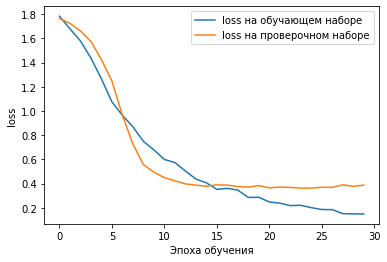

In [ ]:
  import matplotlib.pyplot as plt
  print('Накопительный график loss по эпохам')
  plt.plot(history.history['loss'], 
          label='loss на обучающем наборе')
  plt.plot(history.history['val_loss'], 
          label='loss на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

## Вывод результатов

In [ ]:
# загрузим лучшие веса
models['lstm128'].load_weights('data/best_weightslstm128.h5')

In [ ]:
model2 = models['lstm128']

In [ ]:
# функция вывода результатов получает на вход модель x_test, y_test
def getResults(model, x_test, y_test):
    pred = model.predict(x_test) # получаем предсказание модели
    pred = np.argmax(pred, axis=1) # получаем метку класса с максимальным значением
    result = np.zeros((y_test.shape[1], 2)) # сделаем пустой numpy массив для записи результатов

    # проходимся по всей длине предсказаний
    for i in range(pred.shape[0]):
        # получаем индекс элемента, где у нас 1
        y_true_class_indx = list(y_test[i]).index(max(list(y_test[i])))
        if pred[i] == y_true_class_indx: # если предсказание верно, то увеличиваем счетчик в первом столбце, в строке номера индекса
            result[y_true_class_indx, 0] += 1
        else: # если не верно, то увеличиваем счетчик второго столбца
            result[y_true_class_indx, 1] += 1
    
    # готовим датафрейм с результатами
    result_test_df = pd.DataFrame(result, columns=['true', 'false'])
    result_test_df['percent_true'] = result_test_df['true'] / (result_test_df['true'] + result_test_df['false']) * 100 # считаем процент правильных предсказаний
    result_test_df['tag_name'] = [x[3:] for x in ohe_ytrain.get_feature_names()]
    result_mean = result_test_df['percent_true'].mean()
    print(f'Средний процент правильных предсказаний по всем классам составил: {result_mean}')
    print(result_test_df)

In [ ]:
# результат на изначальном наборе (с 6 классами)
getResults(model2, x_train, y_train)

NameError: ignored

## Формируем табличку с предсказанием классов для проверочного набора

In [ ]:
x_valid_data = data_valid['message'].values

# x_valid_normal = []

# for frase in x_valid_data:
#     new_frase = ''
#     words = frase.split()
#     for word in words:
#         word = word.replace('!', '').replace(',', '').replace('?', '')
#         new_frase += f' {ma.normal_forms(word)[0]}'
#     x_valid_normal.append(new_frase)   

x_valid = tokenizer.texts_to_sequences(x_valid_data)
x_valid = pad_sequences(x_valid, padding='pre')
valid_pred = model2.predict(x_valid)

valid_df = pd.DataFrame()
valid_df['massege'] = list(x_valid_data)
valid_df['softmax'] = list(valid_pred.round(2))
valid_df['class'] = list(np.argmax(valid_pred, axis=1))

valid_df['class'] = np.array([x[3:] for x in ohe_ytrain.get_feature_names()])[valid_df['class']]
valid_df

,massege,softmax,class
0,зачем это надо,"[0.0, 0.0, 0.0, 0.0, 0.36, 0.63]",tag_yes
1,ну,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
2,какая организация?,"[0.02, 0.33, 0.0, 0.26, 0.01, 0.38]",tag_yes
3,во имя чего?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
4,вы тут?,"[0.01, 0.08, 0.0, 0.0, 0.0, 0.9]",tag_yes
5,да ну вас!,"[0.01, 0.01, 0.0, 0.0, 0.0, 0.98]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.03, 0.0, 0.95, 0.01, 0.01]",tag_what_company
7,да хорошо,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
8,с какой радости?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
9,и что дальше?,"[0.0, 0.03, 0.0, 0.0, 0.01, 0.96]",tag_yes


,massege,softmax,class
0,зачем это надо,"[0.0, 0.0, 0.0, 0.0, 0.15, 0.84]",tag_yes
1,ну,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
2,какая организация?,"[0.0, 0.0, 0.0, 0.03, 0.0, 0.97]",tag_yes
3,во имя чего?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
4,вы тут?,"[0.0, 0.01, 0.0, 0.0, 0.02, 0.97]",tag_yes
5,да ну вас!,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
6,"приветствую, а что за организация?","[0.0, 0.08, 0.0, 0.67, 0.23, 0.02]",tag_what_company
7,да хорошо,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes
8,с какой радости?,"[0.01, 0.02, 0.0, 0.02, 0.01, 0.94]",tag_yes
9,и что дальше?,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",tag_yes


In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 8.2MB 21.4MB/s 


In [ ]:
import pymorphy2
ma = pymorphy2.MorphAnalyzer()


In [ ]:
ma.normal_forms('организаций')

['организация']